In [2]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator
import pandas as pd
import glob
from sklearn.metrics import roc_auc_score
import seaborn as sns
import numpy as np
from average_decision_ordering import calc_ado
import warnings
import matplotlib
import matplotlib.image as image
from os import path, getcwd
warnings.simplefilter(action="ignore", category=FutureWarning)
np.seterr(divide="ignore")

home = getcwd()
data_dir = path.join(home, "data")
efp_dir = path.join(data_dir, "efp", "test") 
graph_dir = path.join(home, "graphs")

font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)

et_efp_2_1_0_k_1_b_0.5
AUC(EFP) = 0.8866
0.9535678


TypeError: 'AxesSubplot' object is not subscriptable

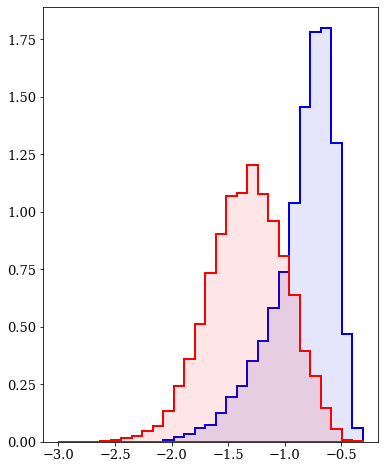

In [209]:
def dif_hist_plot(run_name, pass_ix):
    it_dir = f"results/{run_name}"
    yhat = np.load(f"{data_dir}/raw/et_and_ht_test_pred.npy")
    test_pred = pd.read_feather(f"{it_dir}/p{pass_ix}/test_pred.feather")
    
    # Get indices for run
    df = pd.read_feather(f"{it_dir}/p{pass_ix}/dif_order.feather")
    idx0 = df.idx0.values
    idx1 = df.idx1.values

    # Plot settings
    n_bins = 30
    lw = 2


    e1 = (0, 0, 0.9, 1)
    c1 = (0, 0, 0.9, 0.1)
    
    e2 = (1, 0, 0, 1)
    c2 = (1, 0, 0, 0.1)

    fig_x = 6
    fig_y = 8
    alpha = 0.1

    # Initialize plot
    fig, axs = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))

    # Load EFP data from run
    efp_max = (
        pd.read_csv(f"{it_dir}/p{pass_ix}/dif_order_ado_comparison.csv")
        .iloc[0]
        .efp
    )
    print(efp_max)
    

    efp_data = pd.read_feather(f"{efp_dir}/{efp_max}.feather")
    auc_val = roc_auc_score(efp_data.targets.values, efp_data.nnify.values)
    print(f"AUC(EFP) = {auc_val:.4}")


    ado_w_ll = calc_ado(test_pred.prediction.values, np.hstack(yhat), efp_data.targets.values, 100000)
    print(ado_w_ll)

    # Select dif-order indices
    dif_X0 = np.log10(efp_data.iloc[idx0]["features"].values)
    dif_X1 = np.log10(efp_data.iloc[idx1]["features"].values)


    # Get complete EFP and group by signal/background
    efp_grp = efp_data.groupby(["targets"])
    X0 = np.log10(efp_grp.get_group(0).features.values)
    X1 = np.log10(efp_grp.get_group(1).features.values)

    upper_bound = max(max(X0), max(X1))
    lower_bound = min(min(X0), min(X1))
    if lower_bound == -np.inf:
        lower_bound = -3
    bins = np.linspace(lower_bound, upper_bound, n_bins)

    # Plot histograms
    axs[0].hist(
        X0,
        bins=bins,
        density=True,
        label="Signal in space $EFP_{i}",
        histtype="stepfilled",
        linestyle="-",
        linewidth=lw,
        edgecolor=e1,
        fc=c1,
    )
    axs[0].hist(
        X1,
        bins=bins,
        density=True,
        label="Background in space $EFP_{i}$",
        histtype="stepfilled",
        linestyle="-",
        linewidth=lw,
        edgecolor=e2,
        fc=c2,
    )

    axs[1].hist(
        dif_X0,
        bins=bins,
        density=True,
        label="Signal in subspace $X_{i}$",
        histtype="stepfilled",
        linestyle="-",
        linewidth=lw,
        edgecolor=e1,
        fc=c1,
    )
    axs[1].hist(
        dif_X1,
        bins=bins,
        density=True,
        label="Background in subspace $X_{i}$",
        histtype="stepfilled",
        linestyle="-",
        linewidth=lw,
        edgecolor=e2,
        fc=c2,
    )

    # Increase font
    axs[0].legend(fontsize=12, loc="upper left")
    axs[1].legend(fontsize=12, loc="upper left")

    axs[0].set_xlim(left=lower_bound, right=upper_bound)
    axs[1].set_xlim(left=lower_bound, right=upper_bound)

    # Plot labels
    axs[1].set_xlabel("$\log_{10}$ [EFP Observable]")
    axs[0].set_ylabel("Density")
    axs[1].set_ylabel("Density")
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.subplots_adjust(hspace=0.02)

    # Add the graph to the plot
    gp = efp_max.split("EFP_")[-1]
    ndk = gp.split("_k")[0]
    kappa = gp.split("_")[-3]
    beta = gp.split("_")[-1]
    graph_label = f"efp_{ndk}"
    graph_file = f"{graph_dir}/png/{graph_label}.png"
    #arr_graph = mpimg.imread(graph_file)
    #imagebox = OffsetImage(arr_graph, zoom=0.2+(np.random.random_sample()/1000000.))
    #xlim = axs[0].get_xlim()
    #ylim = axs[0].get_ylim()

    #xpos = bins[int(n_bins / 6)]
    #ypos = ((ylim[0] + ylim[1]) / 2.0) * 1.2
    #xy = (xpos, ypos)
    #ab = AnnotationBbox(imagebox, xy)
    #axs[0].add_artist(ab)
    #xy = (xpos, ypos * 0.7)
    #textarea = TextArea(f"($\\kappa$={kappa}, $\\beta$={beta})")
    #ab = AnnotationBbox(textarea, xy)
    #axs[0].add_artist(ab)

    plt.draw()

    # Save plot
    plt.tight_layout()
    plt.savefig(f"/home/tfaucett/Projects/electron-id/guided_iteration/figures/{run_name}_pass_{pass_ix}.pdf")
    plt.show()

    
run_names = ["7HL_ircSafe"]
for run_name in run_names:
    for pass_ix in range(0,2):
        dif_hist_plot(run_name, pass_ix)

7HL_mass
7HL


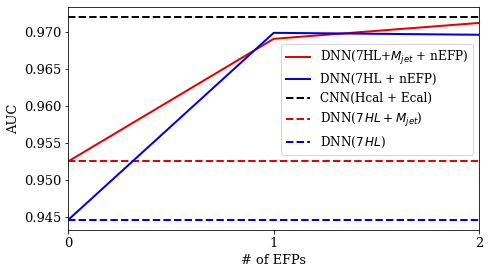

7HL_mass_ircSafe
7HL_ircSafe


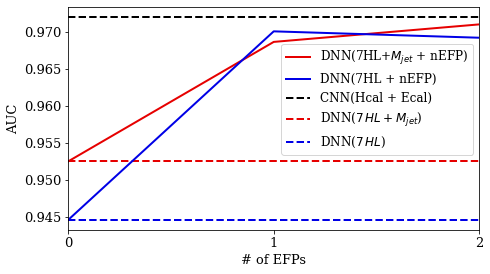

In [19]:
def performance_plot(run_names):
    # Initialize plot
#     fig, (ax0, ax1) = plt.subplots(
#         2, sharex=True, figsize=(8, 6), gridspec_kw={"height_ratios": [3, 1]}
#     )

    fig, ax0 = plt.subplots(figsize=(7, 4))

    hl_only = 0.9446
    hl_mass_benchmark = 0.9525
    ll_benchmark = 0.9720
    ecal_benchmark = 0.9176
    hcal_benchmark = 0.8250
    pass_ix = [0, 1, 2]
    x_min = pass_ix[0]
    x_max = pass_ix[-1]
    
    ax0.hlines(
        ll_benchmark,
        x_min,
        x_max,
        label=f"CNN(Hcal + Ecal)",
        color=c[-1],
        linestyle="dashed",
        linewidth=2
    )

    ax0.hlines(
        hl_mass_benchmark,
        x_min,
        x_max,
        label="DNN($7\, HL + M_{jet}$)",
        color=c[0],
        linestyle="dashed",
        linewidth=2
    )

    ax0.hlines(
        hl_only,
        x_min,
        x_max,
        label=f"DNN($7\, HL$)",
        color=c[1],
        linestyle="dashed",
        linewidth=2
    )    
    
    for ix, run_name in enumerate(run_names):
        it_dir = f"results/{run_name}"
        run_label = run_name.split("_")
        if "ircSafe" in run_label:
            run_label.remove("ircSafe")
        if len(run_label) > 1:
            run_label = run_label[0] + "+" + "$M_{jet}$"
        else:
            run_label = run_label[0]
        df = pd.read_csv(f"{it_dir}/selected_efps.csv")
        efps = df.efp.values

        # Get pass data
        auc_ix = df.auc.values
        ado_ix = df.ado.values
        print(run_name)
        if run_name == "7HL_mass":
            auc_last = 0.9712
        if run_name == "7HL":
            auc_last = 0.9696
        if run_name == "7HL_mass_ircSafe":
            auc_last = 0.9710
        if run_name == "7HL_ircSafe":
            auc_last = 0.9692
        ls = '-'
        if "mass" in run_name:
            auc_ix[0] = hl_mass_benchmark
        else:
            auc_ix[0] = hl_only
        
        auc_ix[-1] = auc_last
        ax0.plot(
            pass_ix,
            auc_ix,
            color=c[ix],
            linewidth=2,
            label="DNN(%s + nEFP)" %run_label,
            linestyle=ls
        )

        ax0.set_ylabel("AUC")
        ax0.xaxis.set_major_locator(MaxNLocator(integer=True))

#         ax1.plot(pass_ix, ado_ix, color=c[ix], label="DNN(%s + nEFP)" %run_label, linestyle=ls)
#         ax1.fill_between(pass_ix, ado_ix, 0.5, color=c[ix], alpha=0.05)


#         ax1.set_ylim([0.5, 1.0])
#         ax1.set_ylabel("$ADO(X_i, LL_i)$")

        # plt.xticks(pass_ix)
        
    plt.legend(bbox_to_anchor=(1.0, 0.31), loc="lower right", ncol=1, fontsize=12)
    plt.xlim([0, x_max])
    plt.xlabel("# of EFPs")
    fig.subplots_adjust(hspace=0.1)
    plt.tight_layout()
    plt.savefig(path.join(home, "figures", f"performance{irc_type}.png"))
    plt.savefig(path.join(home, "figures", f"performance{irc_type}.pdf"))
    plt.show()


c1 = (0.9, 0.0, 0.0, 1)
c2 = (0.0, 0.0, 0.9, 1)
c3 = (0, 0, 0, 1)
c = [c1, c2, c3]    
irc_types = ["", "_ircSafe"]
for irc_type in irc_types:
    run_names = ["7HL_mass"+irc_type, "7HL"+irc_type]
    performance_plot(run_names)

In [151]:
def stats_table(run_name, passes):
    if run_name == "7HL_mass":
        print("7HL + mass")
    else:
        print("7HL")
    it_dir = f"results/{run_name}"
    df = pd.read_csv(f"{it_dir}/selected_efps.csv", index_col=0)
    for pass_ix in range(passes):
#         table = pd.DataFrame()
        if pass_ix >= 1:
            pass_df = df.iloc[pass_ix]
            iteration = int(pass_ix)
            efp = pass_df.efp
            efp_data = pd.read_feather(f"{efp_dir}/{efp}.feather")
            yhat = np.load(f"{data_dir}/raw/et_and_ht_test_pred.npy")
            test_pred = pd.read_feather(f"{it_dir}/p{pass_ix}/test_pred.feather")
            auc_efp = roc_auc_score(efp_data.targets.values, efp_data.nnify.values)
            ado_w_ll = calc_ado(test_pred.prediction.values, np.hstack(yhat), efp_data.targets.values, 100000)
            deets = efp.split("_")
            et_ht = deets[0]
            graph = f"efp_{deets[2]}_{deets[3]}_{deets[4]}"
            kappa = deets[-3]
            beta = deets[-1]
            AUC_hln = pass_df.auc
            ADO_xn_1 = pass_df.ado
#             table_ix = pd.DataFrame({"Iteration":iteration, "EFP":graph, "$\kappa$":kappa, "$\beta$":beta,
#                                   "$\text{ADO}[\text{EFP}, \text{CNN}]_{X_{n-1}}$":ADO_xn_1, "AUC[EFP]":auc_efp, 
#                                   "$\text{ADO}[\text{HLN}_n,\text{CNN}]_{X_{\rm all}}$":ado_w_ll, "$\text{AUC}[\textrm{HLN}_n]$":AUC_hln},
#                                 index=[pass_ix])
#             table = pd.concat([table, table_ix])
            print(f"{iteration} & {graph} & {kappa} & {beta} & {ADO_xn_1:.4} & {auc_efp:.4} & {ado_w_ll:.4} & {AUC_hln:.4}")

run_names = ["7HL", "7HL_mass", "7HL_mass_ircSafe", "7HL_ircSafe"]
for run_name in run_names:
    stats_table(run_name=run_name, passes=3)

7HL
1 & efp_1_0_0 & 2 & 0.5 & 0.8102 & 0.8908 & 0.9804 & 0.9699
2 & efp_5_7_0 & 2 & 0.5 & 0.5775 & 0.7127 & 0.9822 & 0.9712
7HL + mass
1 & efp_6_7_1 & 2 & 1 & 0.6372 & 0.8222 & 0.9792 & 0.9691
2 & efp_1_0_0 & 2 & 0.5 & 0.5738 & 0.8908 & 0.9835 & 0.9721
7HL
1 & efp_3_3_1 & 1 & 0.5 & 0.549 & 0.8468 & 0.9787 & 0.9686
2 & efp_2_1_0 & 1 & 0.5 & 0.5458 & 0.8866 & 0.9837 & 0.9716
7HL
1 & efp_2_1_0 & 1 & 0.5 & 0.8109 & 0.8866 & 0.9813 & 0.9701
2 & efp_4_6_11 & 1 & 1 & 0.5063 & 0.8203 & 0.9821 & 0.97


7HL 0


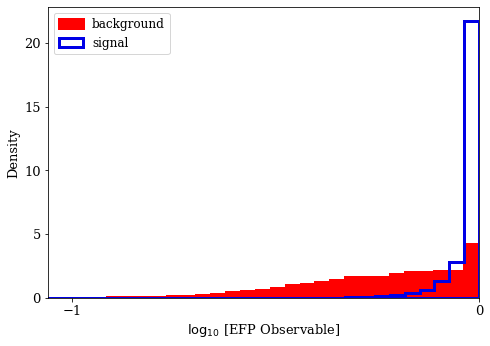

7HL 1


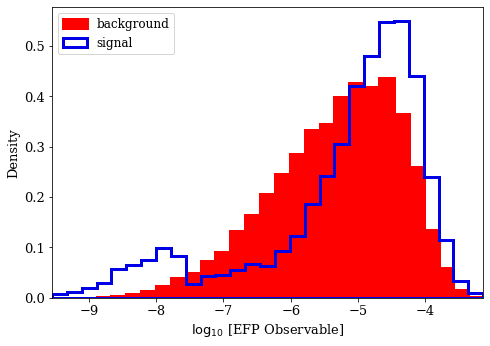

7HL_mass 0


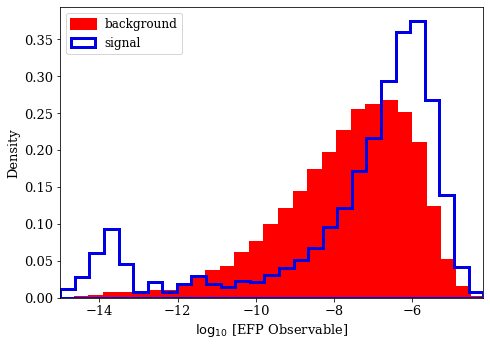

7HL_mass 1


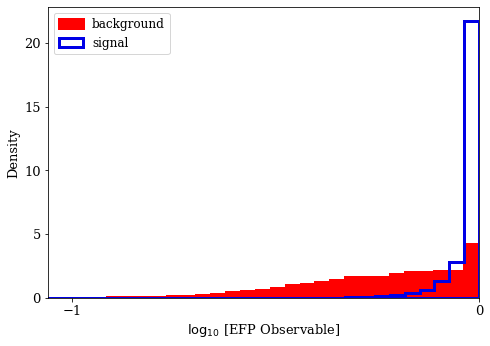

7HL_ircSafe 0


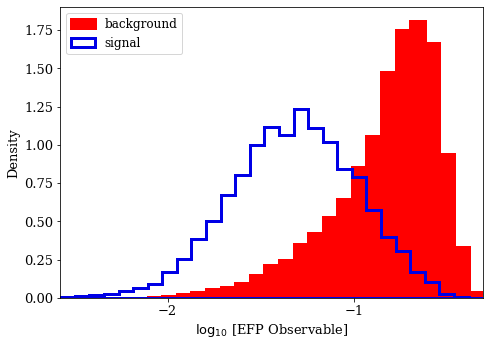

7HL_ircSafe 1


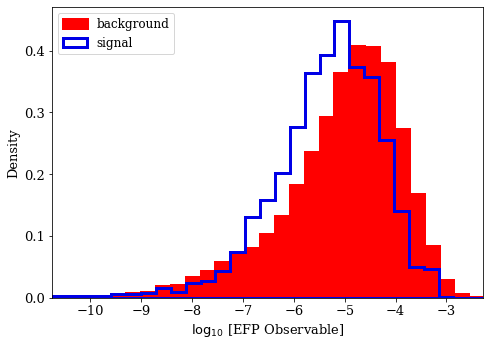

7HL_mass_ircSafe 0


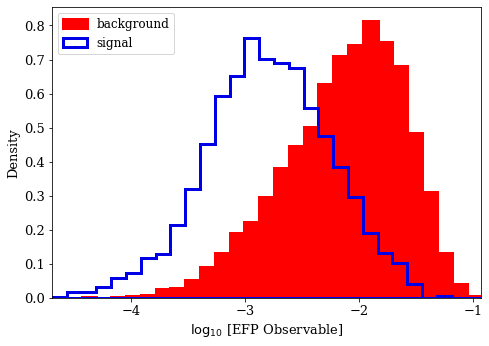

7HL_mass_ircSafe 1


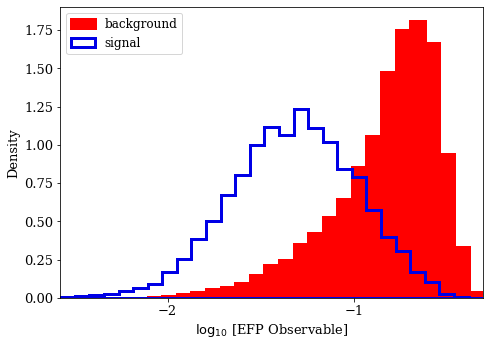

In [293]:
def dif_hist_plot(run_name, pass_ix):
    print(run_name, pass_ix)
    it_dir = f"results/{run_name}"
    yhat = np.load(f"{data_dir}/raw/et_and_ht_test_pred.npy")
    test_pred = pd.read_feather(f"{it_dir}/p{pass_ix}/test_pred.feather")
    
    # Get indices for run
    df = pd.read_feather(f"{it_dir}/p{pass_ix}/dif_order.feather")
    idx0 = df.idx0.values
    idx1 = df.idx1.values

    # Plot settings
    n_bins = 30
    lw = 3

    e0 = (1, 0, 0, 1)
    c0 = (1, 0, 0, 1)
    
    e1 = (0, 0, 0.9, 1)
    c1 = (0, 0, 0.9, 0)


    fig_x = 7
    fig_y = 5
    alpha = 0.1

    # Initialize plot
    fig, ax = plt.subplots(1, figsize=(fig_x, fig_y))

    # Load EFP data from run
    efp_max = (
        pd.read_csv(f"{it_dir}/p{pass_ix}/dif_order_ado_comparison.csv")
        .iloc[0]
        .efp
    )    

    efp_data = pd.read_feather(f"{efp_dir}/{efp_max}.feather")
    
    
    full_hist, full_edges = np.histogram(np.log10(efp_data.features.values), bins=np.linspace(-15,15,100), density=True)
    for ix in range(len(full_hist)):
        hist_count = full_hist[ix]
        if hist_count > 0.001:
            lower_bound = full_edges[ix]
            break
    
    # Get complete EFP and group by signal/background
    efp_grp = efp_data.groupby(["targets"])
    X0 = np.log10(efp_grp.get_group(0).features.values)
    X1 = np.log10(efp_grp.get_group(1).features.values)

    
    upper_bound = max(max(X0), max(X1))
    bins = np.linspace(lower_bound, upper_bound, n_bins)

    ax.hist(
        X0,
        bins=bins,
        density=True,
        label="background",
        histtype="stepfilled",
        linestyle="-",
        linewidth=lw,
        edgecolor=e0,
        fc=c0,
    )    

    # Plot histograms
    ax.hist(
        X1,
        bins=bins,
        density=True,
        label="signal",
        histtype="stepfilled",
        linestyle="-",
        linewidth=lw,
        edgecolor=e1,
        fc=c1,
    )
    

    # Increase font
    ax.legend(fontsize=12, loc="upper left")
    ax.set_xlim(left=lower_bound, right=upper_bound)

    # Plot labels
    ax.set_xlabel("$\log_{10}$ [EFP Observable]")
    ax.set_ylabel("Density")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Save plot
    plt.tight_layout()
    
    plt.savefig(f"/home/tfaucett/Projects/electron-id/guided_iteration/figures/{run_name}/pass{pass_ix+1}/hist.pdf")
    plt.show()

    
run_names = ["7HL", "7HL_mass", "7HL_ircSafe", "7HL_mass_ircSafe"]
for run_name in run_names:
    for pass_ix in range(0,2):
        dif_hist_plot(run_name, pass_ix)

7HL 0


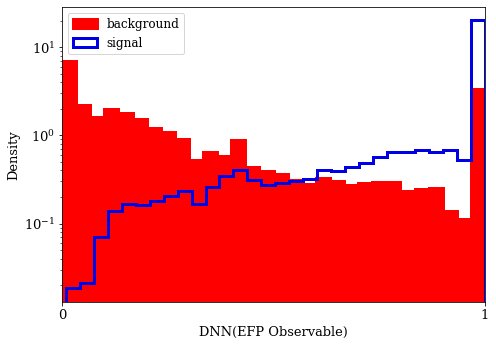

7HL 1


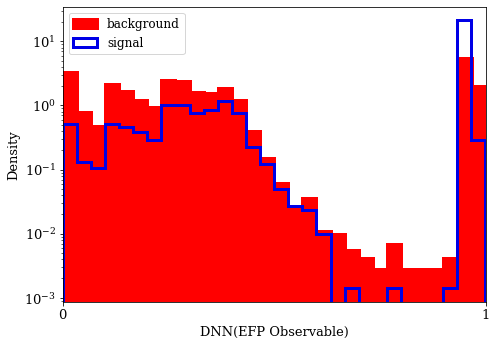

7HL_mass 0


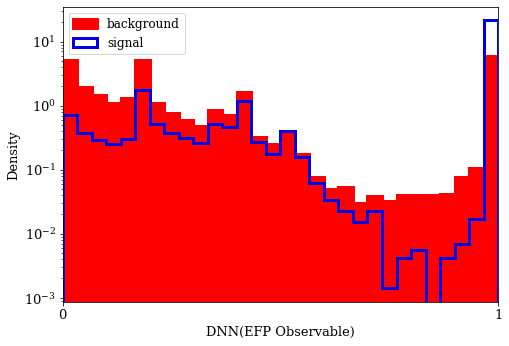

7HL_mass 1


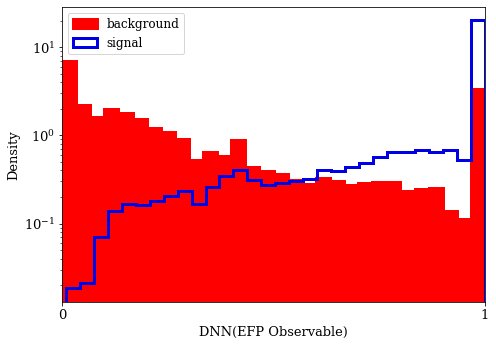

7HL_ircSafe 0


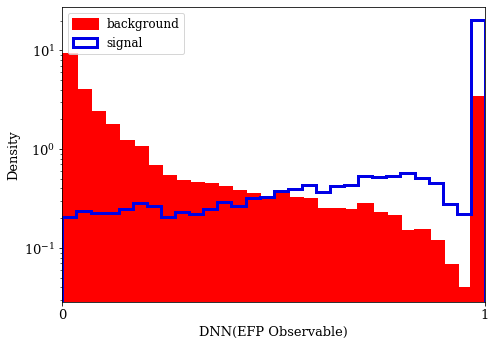

7HL_ircSafe 1


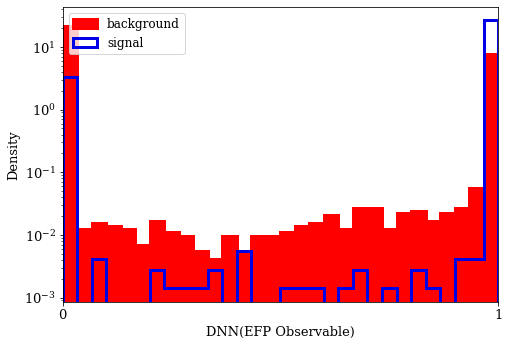

7HL_mass_ircSafe 0


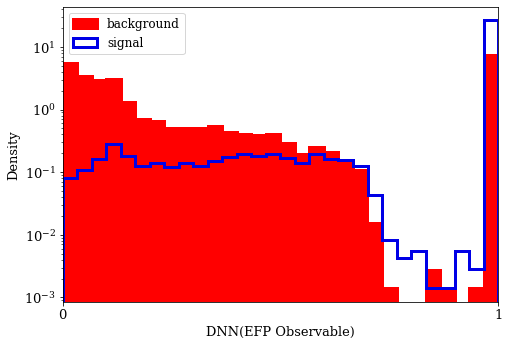

7HL_mass_ircSafe 1


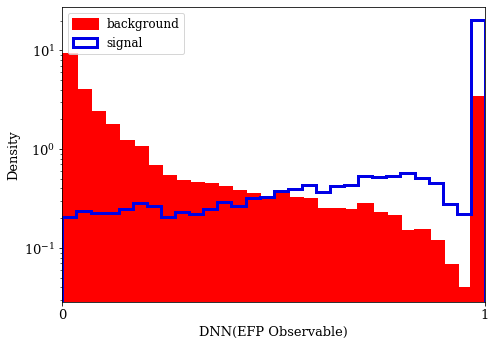

In [305]:
def norm(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def dif_hist_plot(run_name, pass_ix):
    print(run_name, pass_ix)
    it_dir = f"results/{run_name}"
    yhat = np.load(f"{data_dir}/raw/et_and_ht_test_pred.npy")
    test_pred = pd.read_feather(f"{it_dir}/p{pass_ix}/test_pred.feather")
    
    # Get indices for run
    df = pd.read_feather(f"{it_dir}/p{pass_ix}/dif_order.feather")
    idx0 = df.idx0.values
    idx1 = df.idx1.values

    # Plot settings
    n_bins = 30
    lw = 3

    e0 = (1, 0, 0, 1)
    c0 = (1, 0, 0, 1)
    
    e1 = (0, 0, 0.9, 1)
    c1 = (0, 0, 0.9, 0)


    fig_x = 7
    fig_y = 5
    alpha = 0.1

    # Initialize plot
    fig, ax = plt.subplots(1, figsize=(fig_x, fig_y))

    # Load EFP data from run
    efp_max = (
        pd.read_csv(f"{it_dir}/p{pass_ix}/dif_order_ado_comparison.csv")
        .iloc[0]
        .efp
    )    

    efp_data = norm(pd.read_feather(f"{efp_dir}/{efp_max}.feather"))
    
    
    # Get complete EFP and group by signal/background
    efp_grp = efp_data.groupby(["targets"])
    X0 = efp_grp.get_group(0).nnify.values
    X1 = efp_grp.get_group(1).nnify.values

    bins = n_bins
    ax.hist(
        X0,
        bins=bins,
        density=True,
        label="background",
        histtype="stepfilled",
        linestyle="-",
        linewidth=lw,
        edgecolor=e0,
        fc=c0,
    )    

    # Plot histograms
    ax.hist(
        X1,
        bins=bins,
        density=True,
        label="signal",
        histtype="stepfilled",
        linestyle="-",
        linewidth=lw,
        edgecolor=e1,
        fc=c1,
    )
    

    # Increase font
    ax.legend(fontsize=12, loc="upper left")

    # Plot labels
    ax.set_xlabel("DNN(EFP Observable)")
    ax.set_ylabel("Density")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Save plot
    plt.tight_layout()
    plt.xlim([0,1])
    plt.yscale("log")
    
    plt.savefig(f"/home/tfaucett/Projects/electron-id/guided_iteration/figures/{run_name}/pass{pass_ix+1}/nnify.pdf")
    plt.show()

    
run_names = ["7HL", "7HL_mass", "7HL_ircSafe", "7HL_mass_ircSafe"]
for run_name in run_names:
    for pass_ix in range(0,2):
        dif_hist_plot(run_name, pass_ix)